# An agent from langchain that can analyze images and text

Made with inspiration from this source code from langchain:

https://python.langchain.com/docs/how_to/document_loader_pdf/#use-of-multimodal-models

In [1]:
# Install the necessary libraries
# uncomment the following lines to install the necessary libraries

# pip install fitz pillow

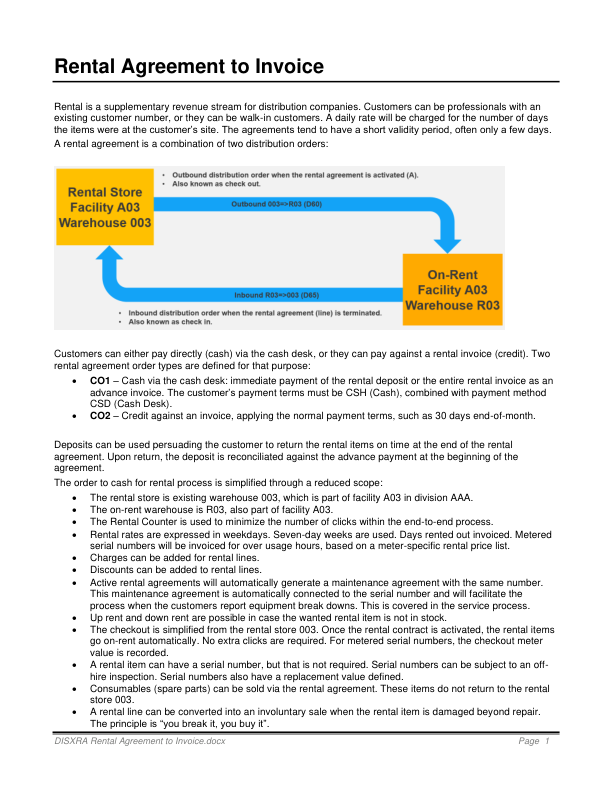

Page 1 analysis:
The document appears to be a detailed overview of a rental agreement system for distribution companies, emphasizing both cash and credit payment methods. Here’s a breakdown of the key points:

### Overview
- **Supplementary Revenue Stream**: Rental services provide additional income for distribution companies.
- **Customer Types**: 
  - Professionals with existing customer numbers.
  - Walk-in customers. 

### Rental Agreement Structure
- **Short Validity**: Agreements generally last only a few days.
- **Combination of Distribution Orders**: Each rental is treated as two distribution orders (outbound and inbound).

### Payment Methods
1. **Cash Payment (CO1)**: Immediate payment either as a deposit or the total rental charge.
   - Payment terms must be cash (CSH) and method cash desk (CSD).
  
2. **Credit Payment (CO2)**: Customers can pay on standard credit terms (e.g., 30 days).

### Deposits and Returns
- **Deposit Use**: Encourages timely return of rental items. De

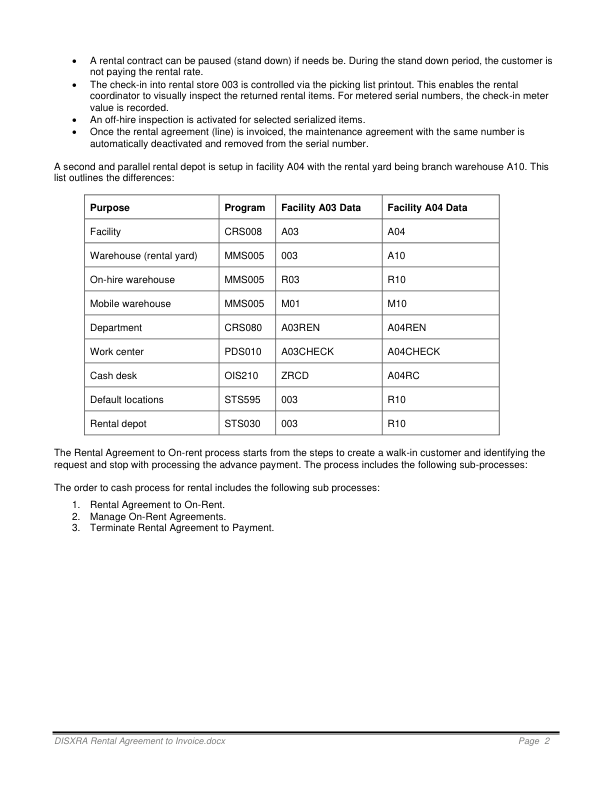

Page 2 analysis:
The content from page 2 of the "DISXRA Rental Agreement to Invoice" document appears to outline key procedures and structures in managing rental agreements and processes related to a rental business. Here’s an analysis of the key points and details:

### Key Points

1. **Contract Pausing**:
   - Rental contracts can be temporarily paused (referred to as "stand down").
   - During this period, the customer will not incur rental charges.

2. **Check-in Process**:
   - Check-ins for rental items at store 003 are monitored through a picking list.
   - This system helps in visually verifying returned items, and it logs meter values for items with serial numbers.

3. **Off-hire Inspection**:
   - Certain serialized rental items undergo an off-hire inspection.

4. **Maintenance Agreement Deactivation**:
   - When a rental agreement is invoiced, any linked maintenance agreement is immediately deactivated, and this is reflected in the system against the serial number.

5. **Set

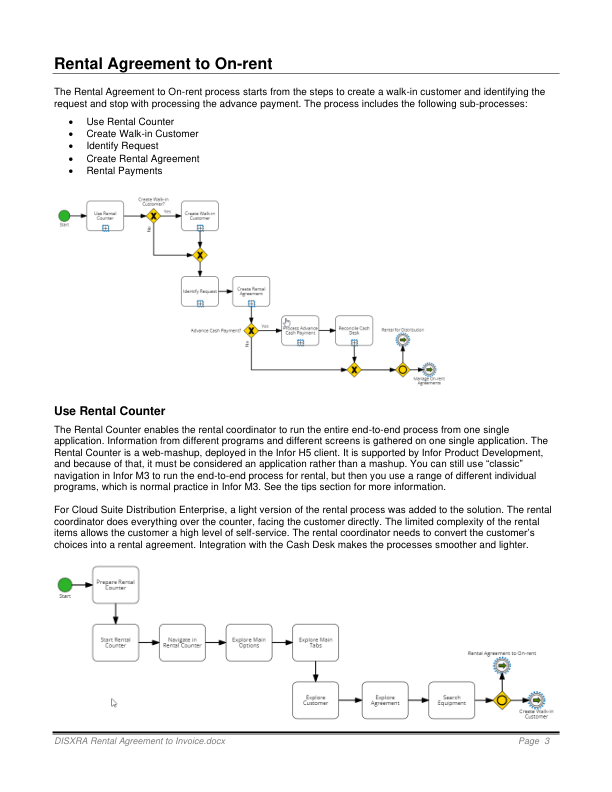

Page 3 analysis:
The content of page 3 of the "DISXRA Rental Agreement to Invoice" document outlines the processes involved in creating a rental agreement for a walk-in customer. Here’s a breakdown of the key points:

### Overview of the Rental Process
- The **Rental Agreement to On-rent** process starts with creating a walk-in customer and identifying their request, concluding with advance payment processing.
  
### Key Sub-processes
1. **Use Rental Counter**
2. **Create Walk-in Customer**
3. **Identify Request**
4. **Create Rental Agreement**
5. **Rental Payments**

### Use of Rental Counter
- The **Rental Counter** serves as a centralized application for rental operations, facilitating an end-to-end process by consolidating information from various programs into one interface.
- It is a web-mashup utilized through the **Infor H5 client** and is regarded as an application rather than a simple mashup.

### Features
- While traditional navigation within **Infor M3** involves multiple i

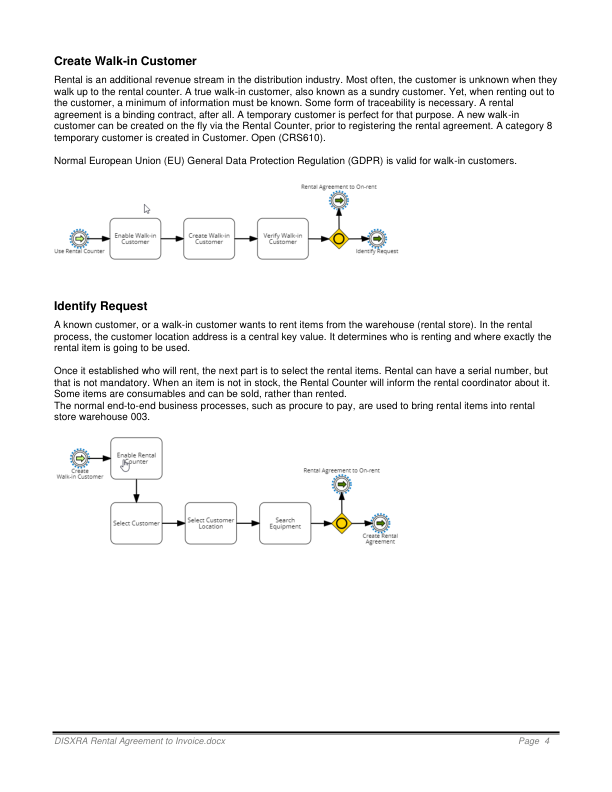

Page 4 analysis:
### Analysis of Page 4 of the DISXRA Rental Agreement Document

#### Content Overview

**Create Walk-in Customer**
- **Concept**: The document discusses the process of creating a new "walk-in" customer (or sundry customer) who typically approaches the rental counter without any prior relationship or identification.
- **Requirements**: Essential information must be collected for traceability, recognizing that a rental agreement constitutes a binding contract.
- **Implementation**: Walk-in customers can be created quickly at the rental counter, specifically as a "category 8 temporary customer" in the system (Customer. Open (CRS610)).
- **Regulatory Compliance**: The process must adhere to the General Data Protection Regulation (GDPR) applicable in the EU, ensuring customer data is managed appropriately.

**Identify Request**
- **Process**: The document outlines the procedure when a known or walk-in customer intends to rent items from the rental store. 
- **Key Data**: Th

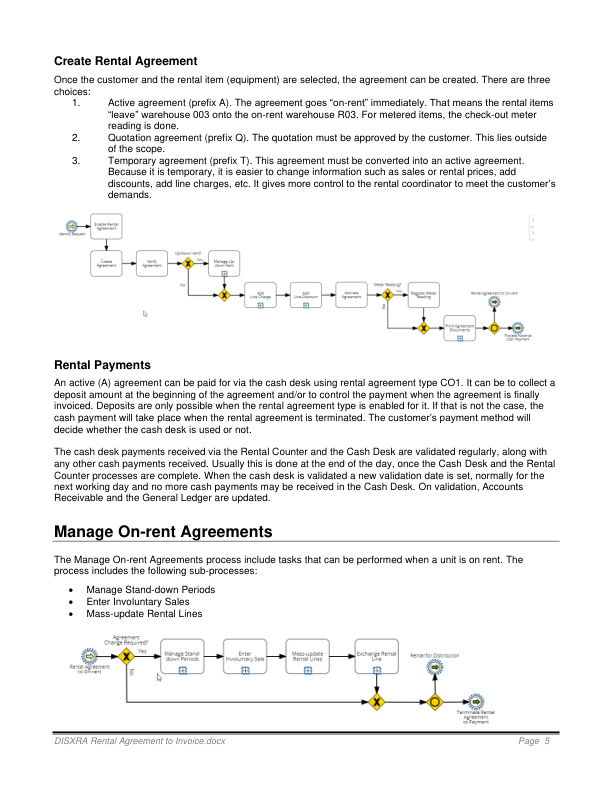

Page 5 analysis:
Sure! Here’s a summary of the content on page 5 of the "DISXRA Rental Agreement to Invoice" document:

### **Create Rental Agreement:**
Once a customer and rental item are selected, three types of agreements can be created:

1. **Active Agreement (prefix A):**
   - Equipment goes “on-rent” immediately.
   - Items move from warehouse 003 to on-rent warehouse R03.
   - Meter readings checked for metered items.

2. **Quotation Agreement (prefix Q):**
   - Requires customer approval.
   - Outside the current scope.

3. **Temporary Agreement (prefix T):**
   - Must be converted into an active agreement.
   - Easier to modify details like prices or discounts.
   - Provides more flexibility for rental coordinators to satisfy customer needs.

### **Rental Payments:**
- An active agreement can be paid via the cash desk using rental agreement type CO1.
- Can include deposit collection or payment control upon final invoicing.
- Deposits are contingent on the agreement type being 

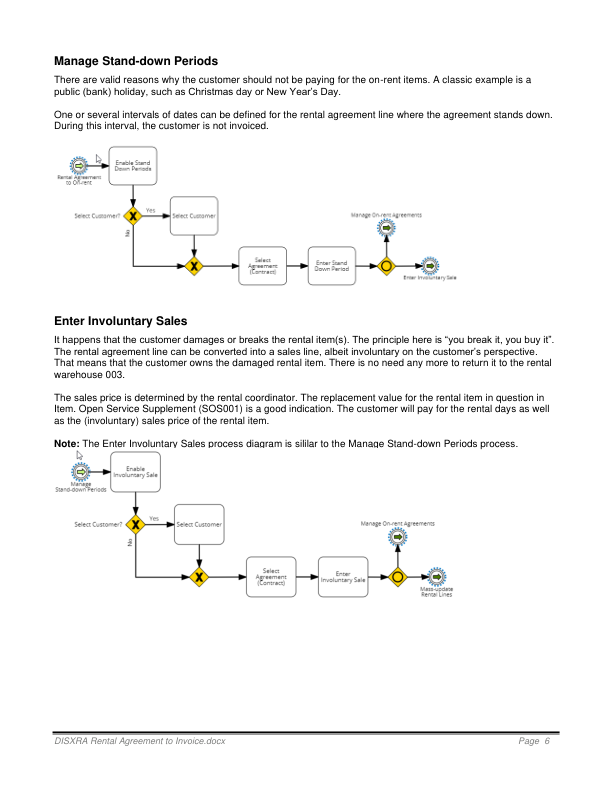

Page 6 analysis:
The content from page 6 of the "DISXRA Rental Agreement to Invoice.docx" document discusses two main processes related to rental agreements: **Manage Stand-down Periods** and **Enter Involuntary Sales**.

### Manage Stand-down Periods
- **Purpose**: This process allows for specific times when a customer is not charged for rental items. 
- **Examples of Stand-down**: Typically includes public holidays like Christmas and New Year’s Day.
- **Implementation**: Users can define date ranges during which the customer is exempt from payment.

### Enter Involuntary Sales
- **Definition**: This process addresses scenarios where the rental items are damaged by the customer. The principle is that if the customer damages an item, they must purchase it.
- **Process**:
  - The affected rental line can switch to a sales line, meaning the customer takes ownership of the damaged item.
  - No return to the rental warehouse is required after the item is deemed broken.
- **Pricing**: The r

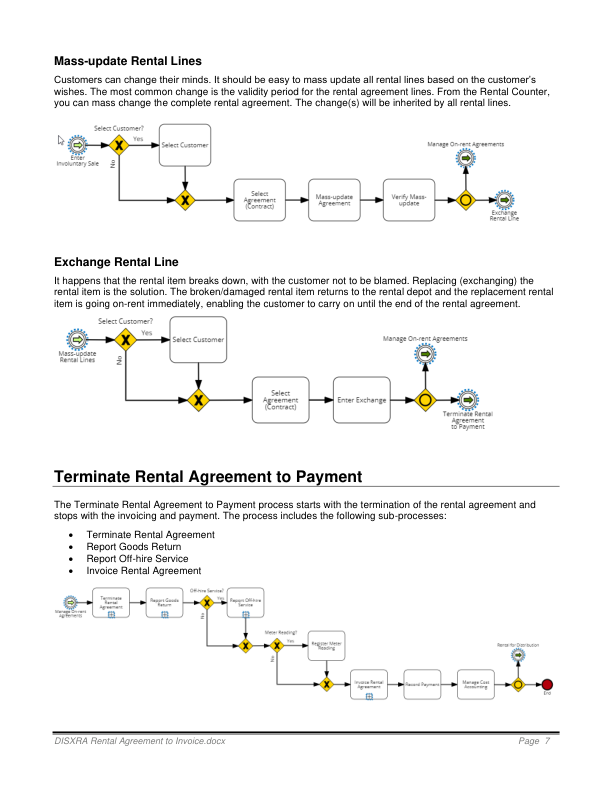

Page 7 analysis:
The content on page 7 of the "DISXRA Rental Agreement to Invoice.docx" outlines processes related to managing rental agreements. Here’s a breakdown of each section:

### 1. Mass-update Rental Lines
- **Functionality**: This feature allows for bulk updates of rental lines based on customer preferences. 
- **Common Change**: The validity period of rental agreements is typically the aspect that may need updating. 
- **Process Overview**: 
  - Users select a customer.
  - They choose the agreement to be mass-updated.
  - Changes are applied to all relevant rental lines.

### 2. Exchange Rental Line
- **Situation**: This process addresses scenarios where a rental item breaks down and is not the customer's fault.
- **Solution**: The broken or damaged item is returned to the depot and replaced with a new one immediately, ensuring continuity for the customer.
- **Process**:
  - Select the customer.
  - Choose the relevant agreement.
  - Execute the exchange process.

### 3. Te

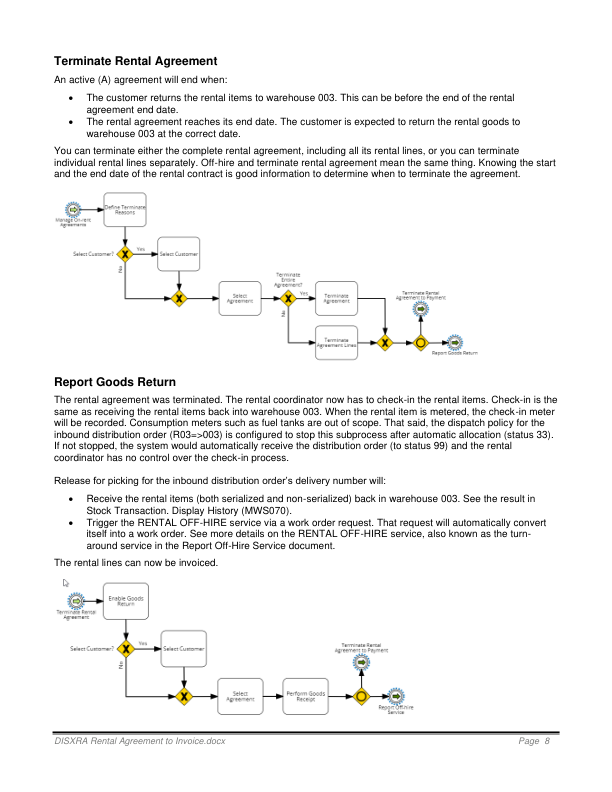

Page 8 analysis:
The content on page 8 of the "DISXRA Rental Agreement to Invoice.docx" focuses on two main sections: terminating a rental agreement and reporting the return of rental goods.

### Terminate Rental Agreement
- **Conditions for Termination**:
  - The agreement ends when items are returned to warehouse 003, either before or at the agreement's end date.
  - Customers must return goods promptly.

- **Types of Termination**:
  - Complete termination of the rental agreement.
  - Individual rental line termination.
  - Terminology clarification: "Off-hire" and "terminate rental agreement" are synonymous.

- **Important Information**: 
  - Knowing both the start and end dates of the rental contract helps determine the termination timeline.

### Report Goods Return
- **Process After Termination**:
  - The rental coordinator is responsible for checking in returned items, which is akin to receiving goods back into the warehouse.
  - Check-in readings are recorded, but consumption m

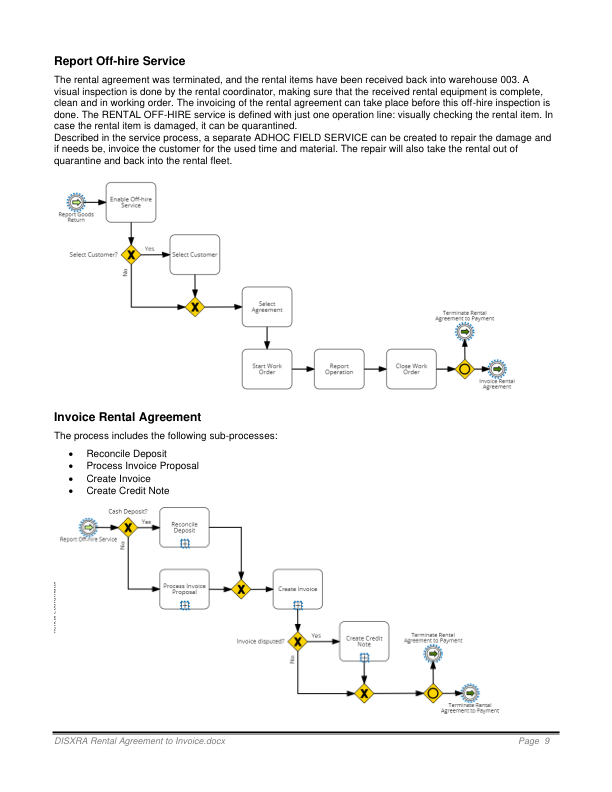

Page 9 analysis:
The content on page 9 of the rental agreement document includes two main sections: "Report Off-hire Service" and "Invoice Rental Agreement." Here’s a summary of each section:

### Report Off-hire Service
- The rental agreement has been terminated, and items are returned to warehouse 003.
- A rental coordinator performs a visual inspection to ensure the equipment is complete, clean, and functional.
- Invoicing can occur before this inspection.
- The "RENTAL OFF-HIRE" service consists of just one operation: visually checking the items.
- If any item is found damaged, it can be placed in quarantine.
- An "ADHOC FIELD SERVICE" can be initiated if repairs are necessary, including invoicing the customer for the repairs and materials used.
- Once repaired, the item can return to the rental fleet.

### Invoice Rental Agreement
This process contains several sub-processes:
- **Reconcile Deposit:** Confirming any deposits made.
- **Process Invoice Proposal:** Preparing an invoice

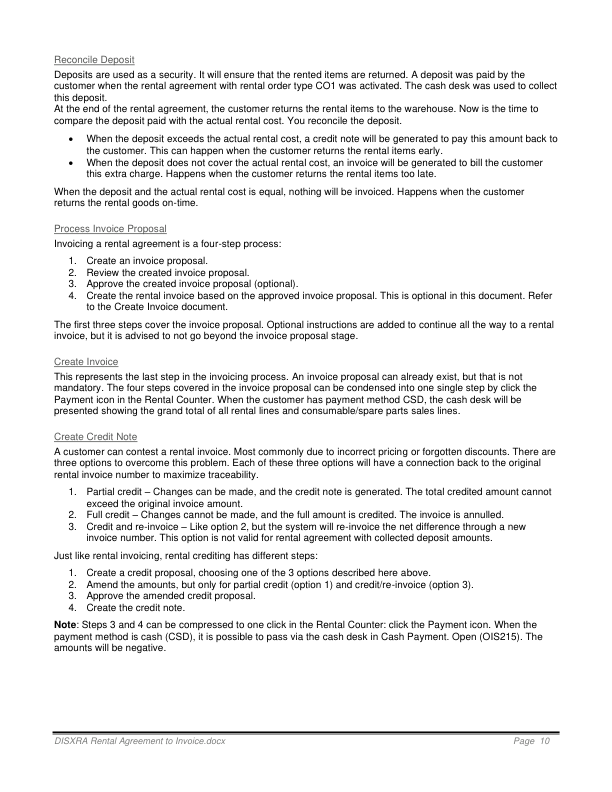

Page 10 analysis:
The content on page 10 of the "DISXRA Rental Agreement to Invoice.docx" outlines several key processes related to handling deposits, invoicing rental agreements, and processing credit notes. Here’s a structured analysis:

### 1. **Reconcile Deposit**
- **Purpose of Deposit**: Serves as security for ensuring the return of rented items.
- **Deposit Handling**:
  - **Collected via Cash Desk**: Customer pays a deposit at the start of the rental.
  - **Reconciliation**: When items are returned, the deposit amount is compared to the actual rental cost.
- **Possible Outcomes**:
  - **Deposit > Rental Cost**: A credit note is generated to refund excess deposit if items are returned early.
  - **Deposit < Rental Cost**: An invoice is created for the additional charges incurred if items are returned late.
  - **Deposit = Rental Cost**: No further action is taken, as the costs match.

### 2. **Process Invoice Proposal**
- **Four-Step Process**:
  1. Create an invoice proposal.
 

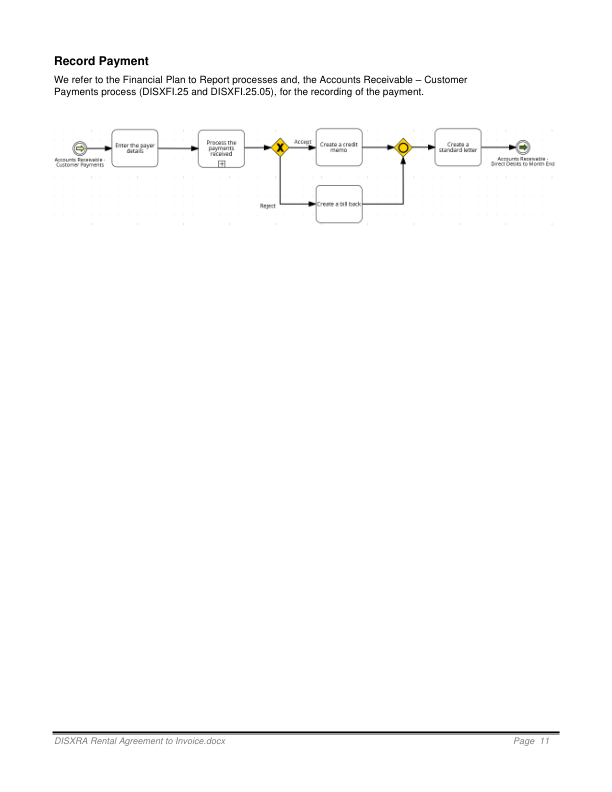

Page 11 analysis:
The content on page 11 of the "DISXRA Rental Agreement to Invoice" document outlines the process for recording customer payments within a financial framework. The key points include:

1. **Reference to Processes**: The document refers to the Financial Plan to Report processes and the Accounts Receivable – Customer Payments process, specifically citing processes DISXFI.25 and DISXFI.25.05. These references suggest a structured approach for handling financial transactions.

2. **Workflow Diagram**: Accompanying the text is a workflow diagram that outlines the steps involved in recording a payment:
   - **Entering Payment Details**: The initial step involves inputting the payment information.
   - **Processing the Payment**: This involves validating and processing the entered details.
   - **Decision Making**: There’s a point where the system accepts or rejects the transaction. 
   - **Credit Note Creation**: If accepted, it may lead to creating a credit note.
   - **Inv

In [2]:
import base64
import io
import fitz
from PIL import Image
from IPython.display import Image as IPImage, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

def pdf_page_to_base64(pdf_path: str, page_number: int):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    return base64.b64encode(buffer.getvalue()).decode("utf-8")

def get_pdf_content(pdf_path: str) -> dict:
    pdf_document = fitz.open(pdf_path)
    text = []
    for page_num in range(len(pdf_document)):
        page = pdf_document.load_page(page_num)
        text.append(page.get_text())
    return text

# Get the content of the PDF file
pdf_text = get_pdf_content("../../data/test_with_images.pdf")

# Path to the PDF file
pdf_path = "../../data/test_with_images.pdf"

# Initialize the multimodal model
llm = ChatOpenAI(model="gpt-4o-mini")

# Iterate over each page and analyze content
for page_num, page_text in enumerate(pdf_text, start=1):
    # Convert the page to a base64 image
    base64_image = pdf_page_to_base64(pdf_path, page_num)
    display(IPImage(data=base64.b64decode(base64_image)))

    # Define the query
    query = f"Analyze the content of page {page_num}"

    # Create the message with text and image
    message = HumanMessage(
        content=[
            {"type": "text", "text": query},
            {"type": "text", "text": page_text},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
            },
        ],
    )
    # Query the model
    response = llm.invoke([message])
    print(f"Page {page_num} analysis:\n{response.content}\n")